# Model Evaluation – VisionGuard Screw Defect Detection
---
##  Notebook Overview 

1. In this notebook, we will:

2. Load the best trained model checkpoint.

3. Evaluate it on the test set.

4. Compute accuracy, precision, recall, and F1-score.

5. Visualize the confusion matrix.

6. Allow the user to upload any image and get prediction.

---

# Libraries Used:

In [2]:

import os
import torch
import torch.nn as nn
import tkinter as tk
from tkinter import filedialog
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


# Configurations

In [3]:
#  Configurations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_dir = r"E:\Final project of Ats\screw_dataset"
batch_size  = 32
num_classes = 6




# ImageNet normalization (same as training)


In [4]:

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]





# Transforms for evaluation


In [5]:

test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

#  Load Test Dataset


In [6]:

test_dataset = datasets.ImageFolder(os.path.join(dataset_dir, "test"), transform=test_tfms)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = test_dataset.classes
print(" Classes found:", class_names)
print(" Test samples:", len(test_dataset))


 Classes found: ['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']
 Test samples: 67


#  Load Best Model


In [7]:

model = models.resnet50(pretrained=False)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.eval()

print(" Model loaded and ready for evaluation")


d:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 Model loaded and ready for evaluation


#  Evaluate on Test Set



In [8]:
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n Classification Report of test set accuracy:")
print(classification_report(y_true, y_pred, target_names=class_names))


 Classification Report of test set accuracy:
                   precision    recall  f1-score   support

             good       0.95      1.00      0.97        37
manipulated_front       1.00      0.67      0.80         6
     scratch_head       0.67      1.00      0.80         6
     scratch_neck       1.00      0.67      0.80         6
      thread_side       0.50      0.50      0.50         6
       thread_top       0.40      0.33      0.36         6

         accuracy                           0.84        67
        macro avg       0.75      0.69      0.71        67
     weighted avg       0.84      0.84      0.83        67



# Confusion Matrix

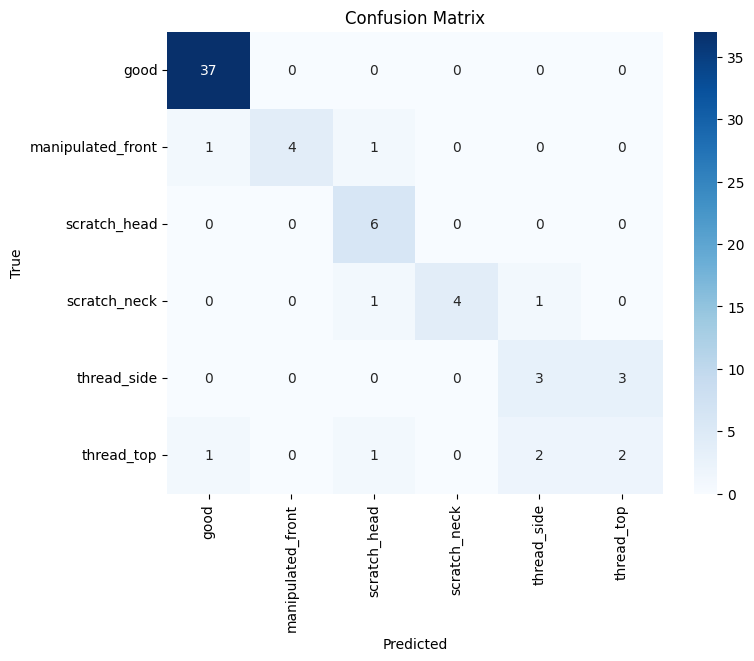

In [9]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Predict on Custom Image (User Input)

 Prediction: good


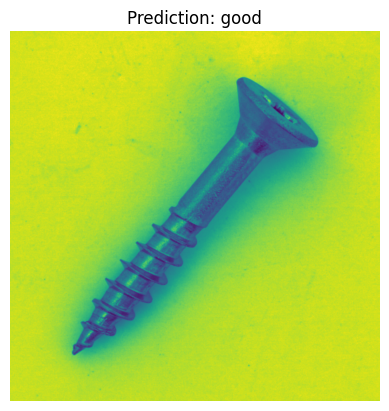

In [10]:

#  Predict function 
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = test_tfms(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(img_t)
        _, pred = torch.max(outputs, 1)
    return class_names[pred.item()]

#  Open file dialog to pick image
def upload_and_predict():
    root = tk.Tk()
    root.withdraw()  # Hide the Tkinter root window
    img_path = filedialog.askopenfilename(
        title="Select an Image",
        filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.bmp")]
    )
    
    if img_path:
        prediction = predict_image(img_path)
        print(f" Prediction: {prediction}")
        
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Prediction: {prediction}")
        plt.show()
    else:
        print(" No file selected.")

#  Run it
upload_and_predict()
